In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas

2023-11-10 16:58:54.853548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 16:58:54.853607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 16:58:54.853633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 16:58:54.859664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file = "./train.tsv"
test_file = "./test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,3:4] = train_data2[:, 3:4] / 12.0 #月を0～1に正規化
train_data2[:,5:6] = train_data2[:,5:6] / 6.0   #曜日を0～1に正規化
train_data2[:,7:8] = train_data2[:,7:8] / 4.0   #天気を0～1に正規化
train_data2 = train_data2.astype(np.float32)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,3:4] = test_data2[:, 3:4] / 12.0 #月を0～1に正規化
test_data2[:,5:6] = test_data2[:,5:6] / 6.0   #曜日を0～1に正規化
test_data2[:,7:8] = test_data2[:,7:8] / 4.0   #天気を0～1に正規化
test_data2 = test_data2.astype(np.float32)

display(train_data2)
display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1],1)
print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)

array([[ 1.    ,  0.    ,  1.    , ...,  0.81  ,  0.    , 16.    ],
       [ 1.    ,  0.    ,  1.    , ...,  0.8   ,  0.    , 40.    ],
       [ 1.    ,  0.    ,  1.    , ...,  0.8   ,  0.    , 32.    ],
       ...,
       [ 1.    ,  0.    , 12.    , ...,  0.58  ,  0.194 , 52.    ],
       [ 1.    ,  0.    , 12.    , ...,  0.62  ,  0.1343, 38.    ],
       [ 1.    ,  0.    , 12.    , ...,  0.66  ,  0.    , 31.    ]],
      dtype=float32)

array([[ 1.    ,  1.    ,  1.    , ...,  0.3788,  0.66  ,  0.    ],
       [ 1.    ,  1.    ,  1.    , ...,  0.3485,  0.66  ,  0.1343],
       [ 1.    ,  1.    ,  1.    , ...,  0.3485,  0.76  ,  0.    ],
       ...,
       [ 1.    ,  1.    , 12.    , ...,  0.2576,  0.6   ,  0.1642],
       [ 1.    ,  1.    , 12.    , ...,  0.2727,  0.56  ,  0.1343],
       [ 1.    ,  1.    , 12.    , ...,  0.2727,  0.65  ,  0.1343]],
      dtype=float32)

[[16.]
 [40.]
 [32.]
 ...
 [52.]
 [38.]
 [31.]]
[[[ 1.    ]
  [ 0.    ]
  [ 1.    ]
  ...
  [ 0.2879]
  [ 0.81  ]
  [ 0.    ]]

 [[ 1.    ]
  [ 0.    ]
  [ 1.    ]
  ...
  [ 0.2727]
  [ 0.8   ]
  [ 0.    ]]

 [[ 1.    ]
  [ 0.    ]
  [ 1.    ]
  ...
  [ 0.2727]
  [ 0.8   ]
  [ 0.    ]]

 ...

 [[ 1.    ]
  [ 0.    ]
  [12.    ]
  ...
  [ 0.4091]
  [ 0.58  ]
  [ 0.194 ]]

 [[ 1.    ]
  [ 0.    ]
  [12.    ]
  ...
  [ 0.3939]
  [ 0.62  ]
  [ 0.1343]]

 [[ 1.    ]
  [ 0.    ]
  [12.    ]
  ...
  [ 0.3788]
  [ 0.66  ]
  [ 0.    ]]]


In [68]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 400  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

In [4]:
y.shape

(8645, 12, 1)

In [79]:
ES = EarlyStopping(mode='auto', patience=20)
model.fit(y, x,
          epochs=100, #100 epochで学習
          validation_split=0.15, #学習データの10%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/100
230/230 [==============================] - 2s 7ms/step - loss: 2816.1653 - accuracy: 0.0106 - val_loss: 7696.9082 - val_accuracy: 0.0077
Epoch 2/100
230/230 [==============================] - 2s 7ms/step - loss: 1766.1692 - accuracy: 0.0109 - val_loss: 4653.8862 - val_accuracy: 0.0077
Epoch 3/100
230/230 [==============================] - 2s 7ms/step - loss: 1702.0424 - accuracy: 0.0094 - val_loss: 4183.3232 - val_accuracy: 0.0077
Epoch 4/100
230/230 [==============================] - 2s 7ms/step - loss: 1685.2666 - accuracy: 0.0114 - val_loss: 4460.4229 - val_accuracy: 0.0077
Epoch 5/100
230/230 [==============================] - 2s 7ms/step - loss: 1377.7109 - accuracy: 0.0108 - val_loss: 4317.7549 - val_accuracy: 0.0077
Epoch 6/100
230/230 [==============================] - 2s 7ms/step - loss: 1217.0126 - accuracy: 0.0114 - val_loss: 4876.9868 - val_accuracy: 0.0077
Epoch 7/100
230/230 [==============================] - 2s 7ms/step - loss: 1326.1125 - accuracy: 0.0112 - 

In [80]:
predicted = model.predict(y)
model.evaluate(y,x)

271/271 [==============================] - 1s 4ms/step - loss: 1177.3018 - accuracy: 0.0118


[1177.3017578125, 0.011798727326095104]

In [81]:
predicted

array([[ 26.89957 ],
       [ 25.503532],
       [ 22.66056 ],
       ...,
       [146.43863 ],
       [121.27517 ],
       [107.59436 ]], dtype=float32)

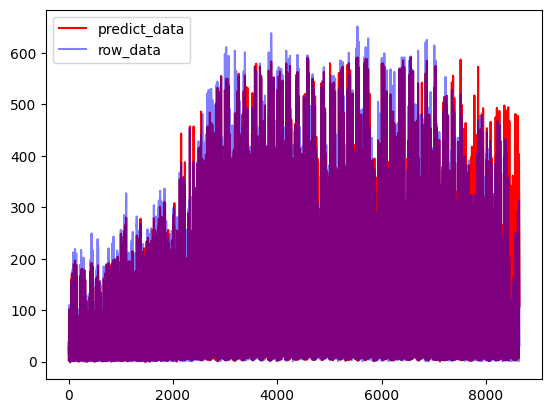

In [82]:
plt.figure()
plt.plot(range(0,len(predicted)),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()